In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import sklearn for Modelling
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import sklearn for Cross Validation
from sklearn.model_selection import train_test_split  , RandomizedSearchCV
# import sklearn  for Evaluation
from sklearn.metrics import accuracy_score , plot_confusion_matrix , classification_report
# import sklearn  for Preprocessing
from sklearn.preprocessing import LabelEncoder ,  StandardScaler

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

1. Read Dataset


In [2]:
# Read csv files into a pandas dataframe
df_star = pd.read_csv("star_classification.csv")
#display first 5 rows from dataset
df_star.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


##### The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

1. `obj_ID `= Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. `alpha` = Right Ascension angle (at J2000 epoch)
3. `delta` = Declination angle (at J2000 epoch)
4. `u` = Ultraviolet filter in the photometric system
5. `g` = Green filter in the photometric system
6. `r` = Red filter in the photometric system
7. `i` = Near Infrared filter in the photometric system
8. `z` = Infrared filter in the photometric system
9. `run_ID` = Run Number used to identify the specific scan
10. `rereun_ID` = Rerun Number to specify how the image was processed
11. `cam_col` = Camera column to identify the scanline within the run
12. `field_ID` = Field number to identify each field
13. `spec_obj_ID` = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. `class` = object class (galaxy, star or quasar object)
15. `redshift` = redshift value based on the increase in wavelength
16. `plate` = plate ID, identifies each plate in SDSS
17. `MJD` = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. `fiber_ID` = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation
Citation

Here, the target column is `class` so it's a multiclass classification problem with three variables `galaxy`, `star` or `quasar `


In [4]:
#select the most interesting columns from dataset
interesting_columns = [
    'alpha', 'delta', 
    'u', 'g', 'r', 'i', 
    'z','class','redshift'
]
df_star = pd.DataFrame(df_star, columns=interesting_columns)

In [5]:
#rename dataset columns
df_star.rename(columns={
    'u': 'ultr_filter', 
    'g': 'green_filter',
    'r': 'red_filter', 
    'i': 'near_infrared_filter',
    'z' : 'infrared_filter'}, inplace=True
)

2. Exploratory Data Analysis and preprocessing

In [6]:
#check the dataset features types and shape
df_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   alpha                 100000 non-null  float64
 1   delta                 100000 non-null  float64
 2   ultr_filter           100000 non-null  float64
 3   green_filter          100000 non-null  float64
 4   red_filter            100000 non-null  float64
 5   near_infrared_filter  100000 non-null  float64
 6   infrared_filter       100000 non-null  float64
 7   class                 100000 non-null  object 
 8   redshift              100000 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.9+ MB


From dataset description, we can see that:
1. The shape (100000, 9).
2. There are no missing values.

In [7]:
#Any duplicated rows ?
df_star.duplicated().sum()

0

In [8]:
#descriptive statistics for dataset
df_star.describe()

,alpha,delta,ultr_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


In [9]:
df_star[df_star['ultr_filter'] == -9999.000000	]
df_star.drop(df_star.index[df_star.ultr_filter == -9999.000000	 ] ,inplace=True)


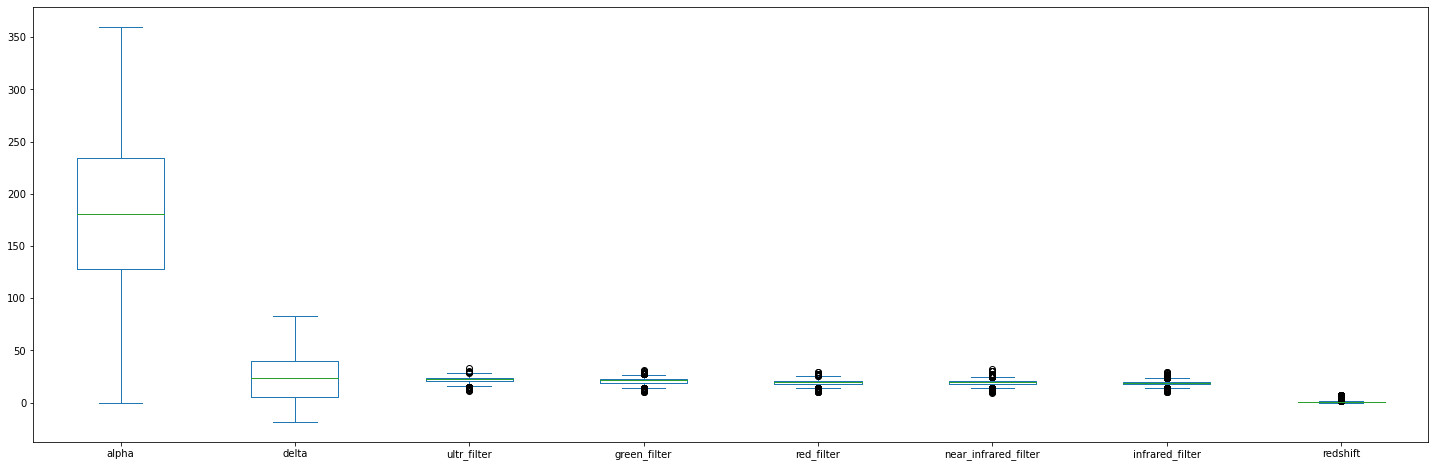

In [10]:
#check outliers by boxplot
df_star.plot.box(sharey=False,figsize=(25,8));

In [11]:
#function to detect outliers in data
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
    # compute IRQ
    iqr = q3 - q1
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
    outliers_removed = [x for x in data if x >= lower_bound and x <= upper_bound]

    return 'Identified outliers:', len(outliers) , 'Non-outlier observations',len(outliers_removed)


#get outliers values
for column in df_star.select_dtypes('number').columns:
    print(f'{column}  {detect_outlier((df_star[column]))}')

alpha  ('Identified outliers:', 0, 'Non-outlier observations', 99999)
delta  ('Identified outliers:', 0, 'Non-outlier observations', 99999)
ultr_filter  ('Identified outliers:', 55, 'Non-outlier observations', 99944)
green_filter  ('Identified outliers:', 98, 'Non-outlier observations', 99901)
red_filter  ('Identified outliers:', 132, 'Non-outlier observations', 99867)
near_infrared_filter  ('Identified outliers:', 198, 'Non-outlier observations', 99801)
infrared_filter  ('Identified outliers:', 319, 'Non-outlier observations', 99680)
redshift  ('Identified outliers:', 8989, 'Non-outlier observations', 91010)


In [12]:
def remove_outlier(df_in, col_name):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(df_in[col_name]), [25, 75])
    # compute IRQ
    iqr = q3 - q1 
    # find lower and upper bounds
    lower_bound  =  q1 - (1.5 * iqr)
    upper_bound =  q3 + (1.5 * iqr)
    #remove outlier values
    df_out = df_in.loc[(df_in[col_name] >= lower_bound) & (df_in[col_name] <= upper_bound)]
    return df_out

for column in df_star.select_dtypes('number').columns:
    df_star = remove_outlier(df_star,column)

GALAXY    0.652550
STAR      0.237406
QSO       0.110044
Name: class, dtype: float64


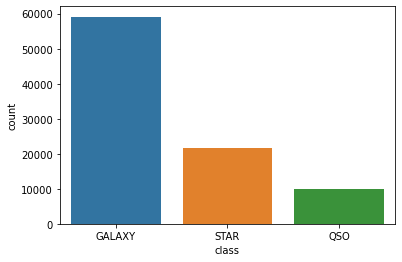

In [13]:
#check the values and its percentage in target column
print(df_star['class'].value_counts(normalize=True))
sns.countplot(df_star['class'],order = df_star['class'].value_counts().index);


We have approximately 65% galaxy, 23% star, and 11% QSO in the dataset so our data suffer from an imbalance target values


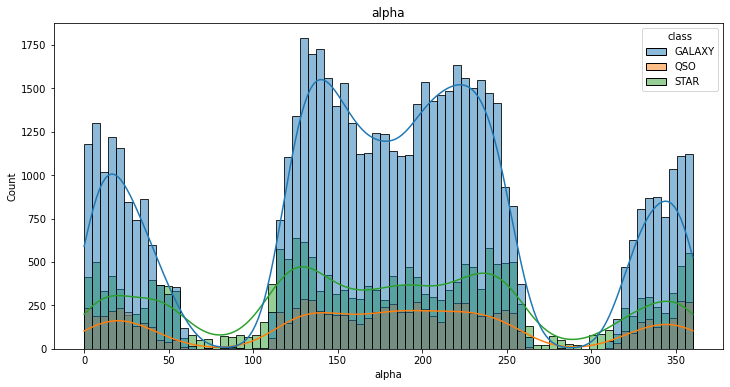

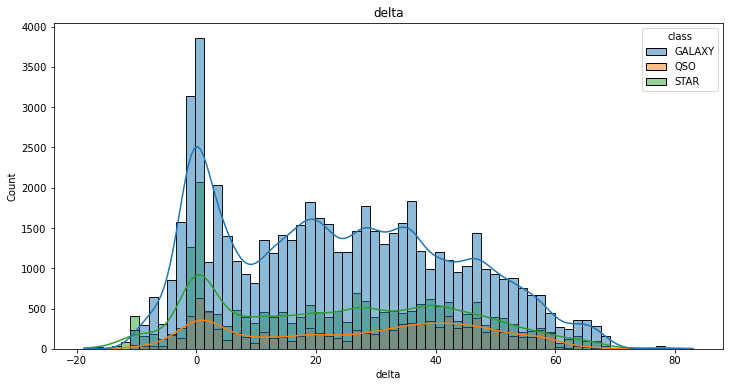

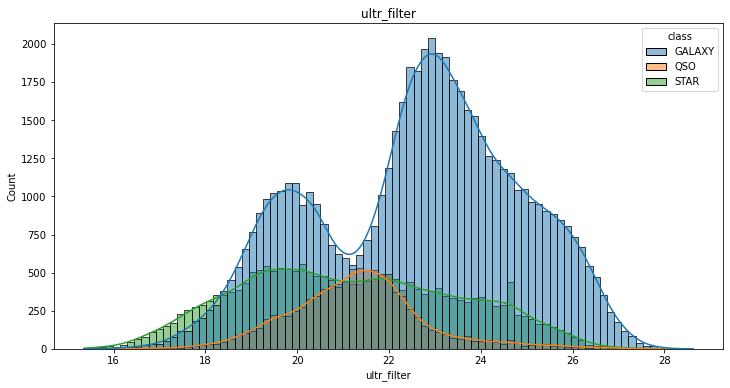

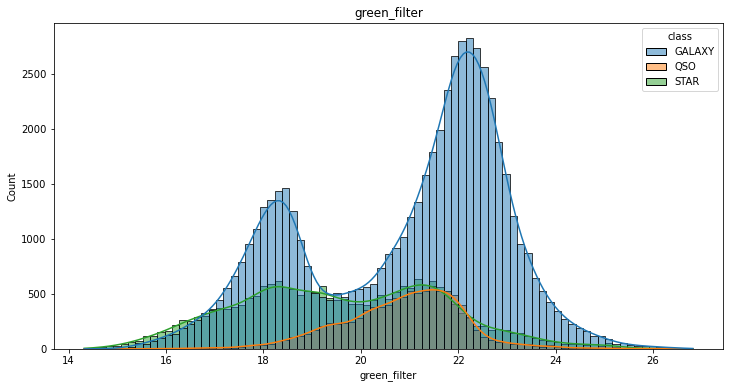

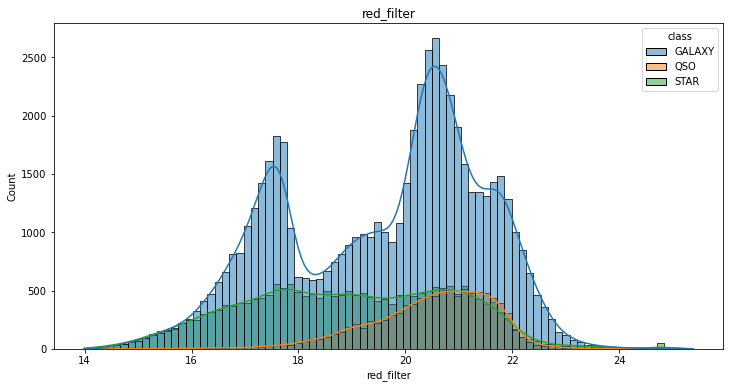

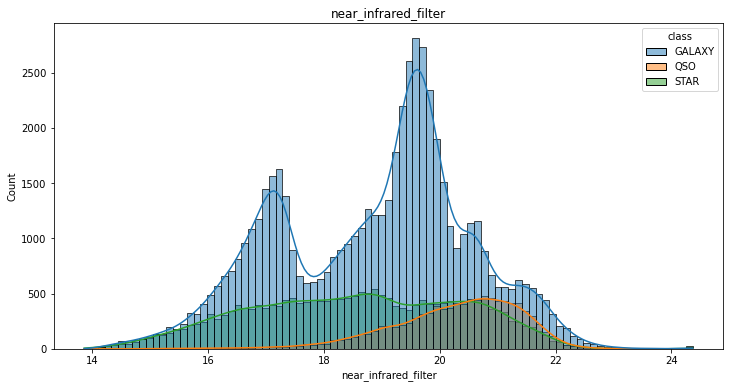

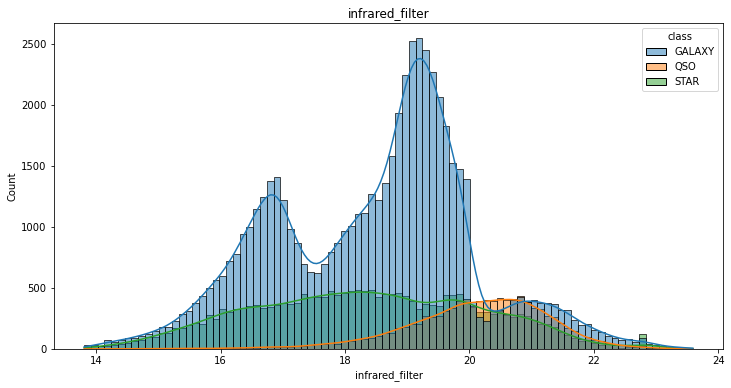

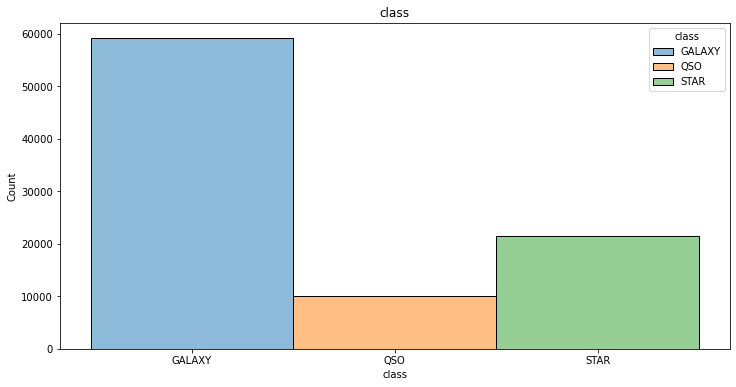

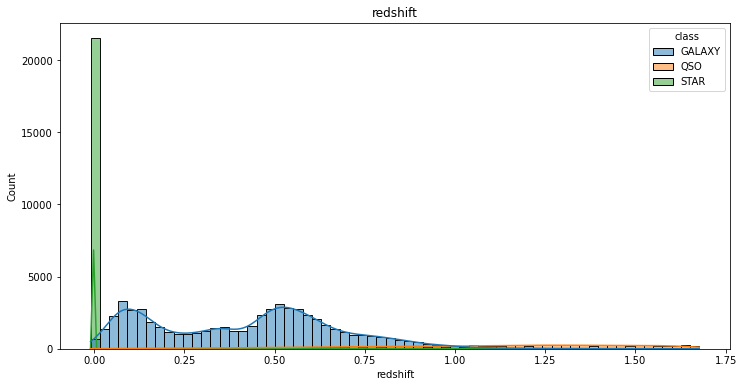

In [15]:
#check distrbution with class
for column in df_star.columns:
    plt.figure(figsize=(12,6))
    sns.histplot(data=df_star, x=column, kde=True, hue="class")
    plt.title(column)
    plt.show()

In [ ]:
#check the distribution of numerical values
df_star.hist(figsize=(13,10));

In [14]:
map_labels = {"GALAXY" :0,
               "STAR" :1,   
                "QSO": 2,
}

df_star["class"] = df_star["class"].map(map_labels)

In [31]:
# target labels encoded 
# Create an encoder object 
#le=LabelEncoder()
# fit and transform target values
#df_star['class'] = le.fit_transform(df_star['class'])

In [15]:
corr = df_star[df_star.columns.difference(["class"])].corrwith(df_star["class"]).abs()
corr.sort_values(ascending=False)

ultr_filter             0.259715
infrared_filter         0.228088
redshift                0.213156
near_infrared_filter    0.168784
green_filter            0.125094
red_filter              0.052130
delta                   0.048705
alpha                   0.003984
dtype: float64

We can see that  `ultr_filter` has the best correlation with `class` followed by `infrared_filter` and `green_filter`



3. Split Dataset into Train and Test Data

In [17]:
# separating data  and target_labels
data = df_star.drop('class' , axis=1)
target = df_star['class']

In [18]:
# Split the data in train/val/test sets, with 60%/20%/20% distribution
X_train_val, X_test, y_train_val, y_test  = train_test_split(data, target, test_size=0.20, random_state=1) 
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1) 


In [19]:
# scale values 
# Create an scaler object 
scaler = StandardScaler()
# fit and transform to scale values in full training set
scaled_X_train = scaler.fit_transform(X_train)
# fit and transform to scale values in test set
scaled_X_test = scaler.transform(X_test)
# fit and transform to scale values in test set
scaled_X_val = scaler.transform(X_val)

In [20]:
# Oversample imbalanced training dataset with SMOTE
oversample = SMOTE()
# transform training dataset
X_smote , y_smote = oversample.fit_resample(scaled_X_train,y_train)

4. Model Training


In this section, we are going to different classification models, tune hyperparameters and finally selecting the best model.

4.1 Decision Tree Classifier


In [22]:
# Train the model with training dataset using default parameters
dt_base = DecisionTreeClassifier(random_state=1)
# Fit to the oversampling training set
dt_base_model= dt_base.fit(X_smote, y_smote)
# Predict using validation dataset
dt_y_pred = dt_base.predict(scaled_X_val)
print(f"Validation dataset AUC: {accuracy_score(y_val, dt_y_pred).round(3)}")
print(classification_report(y_val, dt_y_pred))


Validation dataset AUC: 0.953
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11758
           1       1.00      1.00      1.00      4340
           2       0.75      0.88      0.81      2022

    accuracy                           0.95     18120
   macro avg       0.91      0.94      0.92     18120
weighted avg       0.96      0.95      0.95     18120



4.2 RandomForestClassifier Model

In [23]:
# Train the model with training dataset using default parameters
rf_base = RandomForestClassifier(random_state=1)
# Fit to the oversampling training set
rf_base_model= rf_base.fit(X_smote,y_smote)
rf_y_pred = rf_base.predict(scaled_X_val)
# Predict using validation dataset
print(f"Validation dataset ACC: {accuracy_score(y_val, rf_y_pred).round(4)}")
print(classification_report(y_val, rf_y_pred))


Validation dataset ACC: 0.972
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11758
           1       0.99      1.00      0.99      4340
           2       0.87      0.91      0.89      2022

    accuracy                           0.97     18120
   macro avg       0.95      0.96      0.95     18120
weighted avg       0.97      0.97      0.97     18120



we can see that RandomForestClassifier has the highest AUC score .Now, let's tunned hyperparameters for the best model 

In [68]:
#Tuned hyperpaeameters
param = {
    "n_estimators": [100, 150, 200],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 3, 4],
    "max_features":[None, 2, 5, 7],
    "min_samples_leaf": [1,2, 3],
}
# Define the random grid search model
#n_iter controls the number of searches
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
search_rf = RandomizedSearchCV(rf, param, cv=3, scoring='accuracy', n_iter=10, random_state=2)
# Train the grid search model with training dataset
search_rf.fit(X_smote, y_smote)
print(search_rf.best_score_)
print(search_rf.best_params_)

0.9797063051382509
{'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 5, 'max_depth': None, 'criterion': 'entropy'}


In [98]:
# Train the model again with tuned parameters
rf_tuned = RandomForestClassifier(
    n_estimators = 200,
    criterion="entropy", 
    max_depth=None, 
    max_features=5, 
    min_samples_leaf=1, 
    random_state=2   
)
rf_tunned_model = rf_tuned.fit(X_smote, y_smote)
# Predit using validation dataset
rf_tuned_ypred = rf_tunned_model.predict(scaled_X_val)
print(f"Validation dataset AUC: {accuracy_score(y_val, rf_tuned_ypred).round(3)}")
print(classification_report(y_val, rf_tuned_ypred))

Validation dataset AUC: 0.973
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11758
           1       0.86      0.91      0.88      2022
           2       1.00      1.00      1.00      4340

    accuracy                           0.97     18120
   macro avg       0.95      0.96      0.95     18120
weighted avg       0.97      0.97      0.97     18120



5. Predict on Test Dataset


In [96]:
# Train the model again with tuned parameters
rf_final = RandomForestClassifier(
    n_estimators = 200,
    criterion="entropy", 
    max_depth=None, 
    max_features=5, 
    min_samples_leaf=1, 
    random_state=2   
)
rf_final_model = rf_final.fit(X_smote, y_smote)
# Predit using test dataset
rf_final_ypred = rf_final_model.predict(scaled_X_test)
print(f"test dataset AUC: {accuracy_score(y_test, rf_final_ypred).round(4)}")
print(classification_report(y_test, rf_final_ypred))

test dataset AUC: 0.972
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11884
           1       0.86      0.91      0.88      2005
           2       1.00      1.00      1.00      4231

    accuracy                           0.97     18120
   macro avg       0.95      0.96      0.95     18120
weighted avg       0.97      0.97      0.97     18120



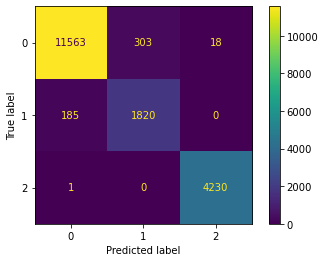

In [97]:
# Calculate the confusion matrix for models
plot_confusion_matrix(rf_final_model,scaled_X_test,y_test)